<a href="https://colab.research.google.com/github/RMCV-Rajapaksha/TeamInception_Datathon/blob/main/task2_eda_and_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 Notebook for "insert model name here"


## Imports and Setup

**Import the Libararies**


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product
import warnings
warnings.filterwarnings('ignore')

### Reading data set files

In [2]:
# Developers please update the paths according to were in your google you place datasets
# i recommend making Rootcode-ML folder and in it Datasets folder and placing the csv files there then you wont have to change below code block
bookings_data = pd.read_csv('./dataset/bookings_train.csv')
tasks_data = pd.read_csv('./dataset/tasks.csv')
staffing_data = pd.read_csv('./dataset/staffing_train.csv')

## EDA


### EDA of Bookings data

lets take a look at the columns and some of their values

In [3]:
staffing_data.head()

,date,section_id,employees_on_duty,total_task_time_minutes
0,2021-01-01,SEC-001,1,834.569483
1,2021-01-01,SEC-002,4,1525.368990
2,2021-01-01,SEC-003,2,662.095279
3,2021-01-01,SEC-004,4,1499.112620
4,2021-01-01,SEC-005,3,1238.533073


In [4]:
staffing_data.describe()

,employees_on_duty,total_task_time_minutes
count,5802.000000,5802.000000
mean,4.458807,1662.296769
std,2.794417,1147.134643
min,1.000000,91.109596
25%,3.000000,859.104314
50%,4.000000,1358.176924
75%,6.000000,2123.936358
max,26.000000,10658.173092


removing unnecessary columns. We wont need the total_task_time_minutes because this data wont be provided as input from the test datasets. We need the date and section_id  because they will be to calculate the actual target value (the thing to be predicted) for task 2.

In [5]:
staffing_data = staffing_data.drop(['total_task_time_minutes'],axis=1)

now lets look at the new table headers again.


In [6]:
staffing_data.head()

,date,section_id,employees_on_duty
0,2021-01-01,SEC-001,1
1,2021-01-01,SEC-002,4
2,2021-01-01,SEC-003,2
3,2021-01-01,SEC-004,4
4,2021-01-01,SEC-005,3


lets get a better idea of how null values have been distributed amoung the columns

In [7]:
staffing_data.isna().sum()

date                 0
section_id           0
employees_on_duty    0
dtype: int64

## Data Preprocessing


### Rearrangement and processing of columns

### Dataset seperation according to section_id

In [8]:
task_counts = staffing_data.groupby("section_id").size().reset_index(name="count")
task_counts

,section_id,count
0,SEC-001,967
1,SEC-002,967
2,SEC-003,967
3,SEC-004,967
4,SEC-005,967
5,SEC-006,967


In [9]:
sec_1_data = staffing_data[staffing_data['section_id'] == 'SEC-001'].copy()
sec_2_data = staffing_data[staffing_data['section_id'] == 'SEC-002'].copy()
sec_3_data = staffing_data[staffing_data['section_id'] == 'SEC-003'].copy()
sec_4_data = staffing_data[staffing_data['section_id'] == 'SEC-004'].copy()
sec_5_data = staffing_data[staffing_data['section_id'] == 'SEC-005'].copy()
sec_6_data = staffing_data[staffing_data['section_id'] == 'SEC-006'].copy()


In [10]:
sec_6_data.head()

,date,section_id,employees_on_duty
5,2021-01-01,SEC-006,11
11,2021-01-04,SEC-006,6
17,2021-01-05,SEC-006,5
23,2021-01-06,SEC-006,10
29,2021-01-07,SEC-006,5


In [11]:
# Convert date column to datetime for all section datasets
for section_data in [sec_1_data, sec_2_data, sec_3_data, sec_4_data, sec_5_data, sec_6_data]:
    section_data['date'] = pd.to_datetime(section_data['date'])
    section_data.set_index('date', inplace=True)
    section_data.sort_index(inplace=True)

In [12]:
def remove_outliers_iqr(data, column):
    """Remove outliers using IQR method"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Create a copy without outliers
    data_clean = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)].copy()
    
    print(f"Original data points: {len(data)}")
    print(f"Data points after outlier removal: {len(data_clean)}")
    print(f"Outliers removed: {len(data) - len(data_clean)}")
    
    return data_clean

In [13]:
def split_time_series(data, train_ratio=0.7, val_ratio=0.15):
    """Split time series data into train, validation, and test sets"""
    n = len(data)
    train_size = int(n * train_ratio)
    val_size = int(n * val_ratio)
    
    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size:train_size + val_size]
    test_data = data.iloc[train_size + val_size:]
    
    print(f"Train set: {len(train_data)} samples")
    print(f"Validation set: {len(val_data)} samples") 
    print(f"Test set: {len(test_data)} samples")
    
    return train_data, val_data, test_data

In [14]:
def find_best_arima(train_data, max_p=3, max_d=2, max_q=3):
    """Find best ARIMA parameters using AIC"""
    best_aic = float('inf')
    best_params = None
    best_model = None
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(train_data['employees_on_duty'], order=(p, d, q))
                    fitted_model = model.fit()
                    aic = fitted_model.aic
                    
                    if aic < best_aic:
                        best_aic = aic
                        best_params = (p, d, q)
                        best_model = fitted_model
                        
                except:
                    continue
    
    print(f"Best ARIMA parameters: {best_params}")
    print(f"Best AIC: {best_aic:.2f}")
    
    return best_model, best_params

In [15]:
print("=" * 50)
print("PROCESSING SECTION 1 (SEC-001)")
print("=" * 50)

# Remove outliers from training data only
sec_1_clean = remove_outliers_iqr(sec_1_data, 'employees_on_duty')

# Split the cleaned data
train_1, val_1, test_1 = split_time_series(sec_1_clean)

# Find best ARIMA model
best_model_1, best_params_1 = find_best_arima(train_1)

print("\nSection 1 Model Summary:")
print(best_model_1.summary())

PROCESSING SECTION 1 (SEC-001)
Original data points: 967
Data points after outlier removal: 955
Outliers removed: 12
Train set: 668 samples
Validation set: 143 samples
Test set: 144 samples
Best ARIMA parameters: (3, 1, 1)
Best AIC: 2299.89

Section 1 Model Summary:
                               SARIMAX Results                                
Dep. Variable:      employees_on_duty   No. Observations:                  668
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -1144.943
Date:                Thu, 21 Aug 2025   AIC                           2299.886
Time:                        20:55:27   BIC                           2322.400
Sample:                             0   HQIC                          2308.608
                                - 668                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [16]:
print("=" * 50)
print("PROCESSING SECTION 2 (SEC-002)")
print("=" * 50)

# Remove outliers from training data only
sec_2_clean = remove_outliers_iqr(sec_2_data, 'employees_on_duty')

# Split the cleaned data
train_2, val_2, test_2 = split_time_series(sec_2_clean)

# Find best ARIMA model
best_model_2, best_params_2 = find_best_arima(train_2)

print("\nSection 2 Model Summary:")
print(best_model_2.summary())

PROCESSING SECTION 2 (SEC-002)
Original data points: 967
Data points after outlier removal: 954
Outliers removed: 13
Train set: 667 samples
Validation set: 143 samples
Test set: 144 samples
Best ARIMA parameters: (2, 1, 3)
Best AIC: 2450.29

Section 2 Model Summary:
                               SARIMAX Results                                
Dep. Variable:      employees_on_duty   No. Observations:                  667
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1219.147
Date:                Thu, 21 Aug 2025   AIC                           2450.294
Time:                        20:56:01   BIC                           2477.302
Sample:                             0   HQIC                          2460.758
                                - 667                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [17]:
print("=" * 50)
print("PROCESSING SECTION 3 (SEC-003)")
print("=" * 50)

# Remove outliers from training data only
sec_3_clean = remove_outliers_iqr(sec_3_data, 'employees_on_duty')

# Split the cleaned data
train_3, val_3, test_3 = split_time_series(sec_3_clean)

# Find best ARIMA model
best_model_3, best_params_3 = find_best_arima(train_3)

print("\nSection 3 Model Summary:")
print(best_model_3.summary())

PROCESSING SECTION 3 (SEC-003)
Original data points: 967
Data points after outlier removal: 962
Outliers removed: 5
Train set: 673 samples
Validation set: 144 samples
Test set: 145 samples
Best ARIMA parameters: (2, 0, 0)
Best AIC: 2333.33

Section 3 Model Summary:
                               SARIMAX Results                                
Dep. Variable:      employees_on_duty   No. Observations:                  673
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1162.667
Date:                Thu, 21 Aug 2025   AIC                           2333.334
Time:                        20:56:30   BIC                           2351.381
Sample:                             0   HQIC                          2340.322
                                - 673                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

In [18]:
print("=" * 50)
print("PROCESSING SECTION 4 (SEC-004)")
print("=" * 50)

# Remove outliers from training data only
sec_4_clean = remove_outliers_iqr(sec_4_data, 'employees_on_duty')

# Split the cleaned data
train_4, val_4, test_4 = split_time_series(sec_4_clean)

# Find best ARIMA model
best_model_4, best_params_4 = find_best_arima(train_4)

print("\nSection 4 Model Summary:")
print(best_model_4.summary())

PROCESSING SECTION 4 (SEC-004)
Original data points: 967
Data points after outlier removal: 953
Outliers removed: 14
Train set: 667 samples
Validation set: 142 samples
Test set: 144 samples
Best ARIMA parameters: (3, 0, 3)
Best AIC: 2318.51

Section 4 Model Summary:
                               SARIMAX Results                                
Dep. Variable:      employees_on_duty   No. Observations:                  667
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1151.255
Date:                Thu, 21 Aug 2025   AIC                           2318.511
Time:                        20:57:01   BIC                           2354.533
Sample:                             0   HQIC                          2332.466
                                - 667                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [19]:
print("=" * 50)
print("PROCESSING SECTION 5 (SEC-005)")
print("=" * 50)

# Remove outliers from training data only
sec_5_clean = remove_outliers_iqr(sec_5_data, 'employees_on_duty')

# Split the cleaned data
train_5, val_5, test_5 = split_time_series(sec_5_clean)

# Find best ARIMA model
best_model_5, best_params_5 = find_best_arima(train_5)

print("\nSection 5 Model Summary:")
print(best_model_5.summary())

PROCESSING SECTION 5 (SEC-005)
Original data points: 967
Data points after outlier removal: 939
Outliers removed: 28
Train set: 657 samples
Validation set: 140 samples
Test set: 142 samples
Best ARIMA parameters: (0, 1, 1)
Best AIC: 3362.44

Section 5 Model Summary:
                               SARIMAX Results                                
Dep. Variable:      employees_on_duty   No. Observations:                  657
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1679.221
Date:                Thu, 21 Aug 2025   AIC                           3362.441
Time:                        20:57:32   BIC                           3371.414
Sample:                             0   HQIC                          3365.920
                                - 657                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [20]:
print("=" * 50)
print("PROCESSING SECTION 6 (SEC-006)")
print("=" * 50)

# Remove outliers from training data only
sec_6_clean = remove_outliers_iqr(sec_6_data, 'employees_on_duty')

# Split the cleaned data
train_6, val_6, test_6 = split_time_series(sec_6_clean)

# Find best ARIMA model
best_model_6, best_params_6 = find_best_arima(train_6)

print("\nSection 6 Model Summary:")
print(best_model_6.summary())

PROCESSING SECTION 6 (SEC-006)
Original data points: 967
Data points after outlier removal: 943
Outliers removed: 24
Train set: 660 samples
Validation set: 141 samples
Test set: 142 samples
Best ARIMA parameters: (2, 0, 2)
Best AIC: 2976.37

Section 6 Model Summary:
                               SARIMAX Results                                
Dep. Variable:      employees_on_duty   No. Observations:                  660
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1482.184
Date:                Thu, 21 Aug 2025   AIC                           2976.368
Time:                        20:58:07   BIC                           3003.322
Sample:                             0   HQIC                          2986.816
                                - 660                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [21]:
def make_predictions(model, train_data, val_data, test_data):
    """Make predictions on validation and test sets"""
    
    # Predict on validation set
    val_start = len(train_data)
    val_end = val_start + len(val_data) - 1
    val_pred = model.predict(start=val_start, end=val_end)
    
    # Predict on test set
    test_start = len(train_data) + len(val_data)
    test_end = test_start + len(test_data) - 1
    test_pred = model.predict(start=test_start, end=test_end)
    
    return val_pred, test_pred

def calculate_metrics(actual, predicted):
    """Calculate evaluation metrics"""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    accuracy = r2_score(actual, predicted)

    return mae, rmse, mape, accuracy

In [22]:
# Store all models and data for plotting
models = [best_model_1, best_model_2, best_model_3, best_model_4, best_model_5, best_model_6]
train_sets = [train_1, train_2, train_3, train_4, train_5, train_6]
val_sets = [val_1, val_2, val_3, val_4, val_5, val_6]
test_sets = [test_1, test_2, test_3, test_4, test_5, test_6]
section_names = ['SEC-001', 'SEC-002', 'SEC-003', 'SEC-004', 'SEC-005', 'SEC-006']

# Generate predictions for all sections
all_predictions = {}
all_metrics = {}

for i, section in enumerate(section_names):
    print(f"\nGenerating predictions for {section}...")
    
    val_pred, test_pred = make_predictions(models[i], train_sets[i], val_sets[i], test_sets[i])
    
    # Calculate metrics
    val_mae, val_rmse, val_mape, val_acc = calculate_metrics(val_sets[i]['employees_on_duty'], val_pred)
    test_mae, test_rmse, test_mape, test_acc = calculate_metrics(test_sets[i]['employees_on_duty'], test_pred)
    
    all_predictions[section] = {
        'val_pred': val_pred,
        'test_pred': test_pred
    }
    
    all_metrics[section] = {
        'val_metrics': {'MAE': val_mae, 'RMSE': val_rmse, 'MAPE': val_mape, 'ACC': val_acc},
        'test_metrics': {'MAE': test_mae, 'RMSE': test_rmse, 'MAPE': test_mape, 'ACC': test_acc}
    }
    
    print(f"Validation - MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}, MAPE: {val_mape:.2f}%, ACC: {val_acc:.2f}")
    print(f"Test - MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, MAPE: {test_mape:.2f}%, ACC: {test_acc:.2f}")


Generating predictions for SEC-001...
Validation - MAE: 0.95, RMSE: 1.18, MAPE: nan%, ACC: -0.00
Test - MAE: 0.95, RMSE: 1.19, MAPE: nan%, ACC: -0.00

Generating predictions for SEC-002...
Validation - MAE: 1.37, RMSE: 1.71, MAPE: nan%, ACC: -0.00
Test - MAE: 1.23, RMSE: 1.50, MAPE: nan%, ACC: -0.03

Generating predictions for SEC-003...
Validation - MAE: 0.94, RMSE: 1.24, MAPE: nan%, ACC: -0.08
Test - MAE: 0.94, RMSE: 1.22, MAPE: nan%, ACC: -0.02

Generating predictions for SEC-004...
Validation - MAE: 1.04, RMSE: 1.35, MAPE: nan%, ACC: -0.03
Test - MAE: 0.95, RMSE: 1.18, MAPE: nan%, ACC: -0.03

Generating predictions for SEC-005...
Validation - MAE: 2.32, RMSE: 2.85, MAPE: nan%, ACC: -0.09
Test - MAE: 2.69, RMSE: 3.20, MAPE: nan%, ACC: -0.08

Generating predictions for SEC-006...
Validation - MAE: 1.80, RMSE: 2.17, MAPE: nan%, ACC: -0.02
Test - MAE: 1.70, RMSE: 2.11, MAPE: nan%, ACC: -0.05


In [23]:
def plot_predictions(section_idx, section_name):
    """Plot actual vs predicted values for a section"""
    
    train_data = train_sets[section_idx]
    val_data = val_sets[section_idx]
    test_data = test_sets[section_idx]
    val_pred = all_predictions[section_name]['val_pred']
    test_pred = all_predictions[section_name]['test_pred']
    
    plt.figure(figsize=(15, 8))
    
    # Plot actual data
    plt.plot(train_data.index, train_data['employees_on_duty'], 
             label='Training Data', color='blue', alpha=0.7)
    plt.plot(val_data.index, val_data['employees_on_duty'], 
             label='Validation Actual', color='green', alpha=0.7)
    plt.plot(test_data.index, test_data['employees_on_duty'], 
             label='Test Actual', color='red', alpha=0.7)
    
    # Plot predictions
    plt.plot(val_data.index, val_pred, 
             label='Validation Predicted', color='lightgreen', linestyle='--', linewidth=2)
    plt.plot(test_data.index, test_pred, 
             label='Test Predicted', color='orange', linestyle='--', linewidth=2)
    
    plt.title(f'{section_name} - Actual vs Predicted Employees', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Employees', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Add metrics text
    val_metrics = all_metrics[section_name]['val_metrics']
    test_metrics = all_metrics[section_name]['test_metrics']
    
    metrics_text = f"Validation: MAE={val_metrics['MAE']:.2f}, RMSE={val_metrics['RMSE']:.2f}, MAPE={val_metrics['MAPE']:.1f}%\n"
    metrics_text += f"Test: MAE={test_metrics['MAE']:.2f}, RMSE={test_metrics['RMSE']:.2f}, MAPE={test_metrics['MAPE']:.1f}%"
    
    plt.text(0.02, 0.98, metrics_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.show()

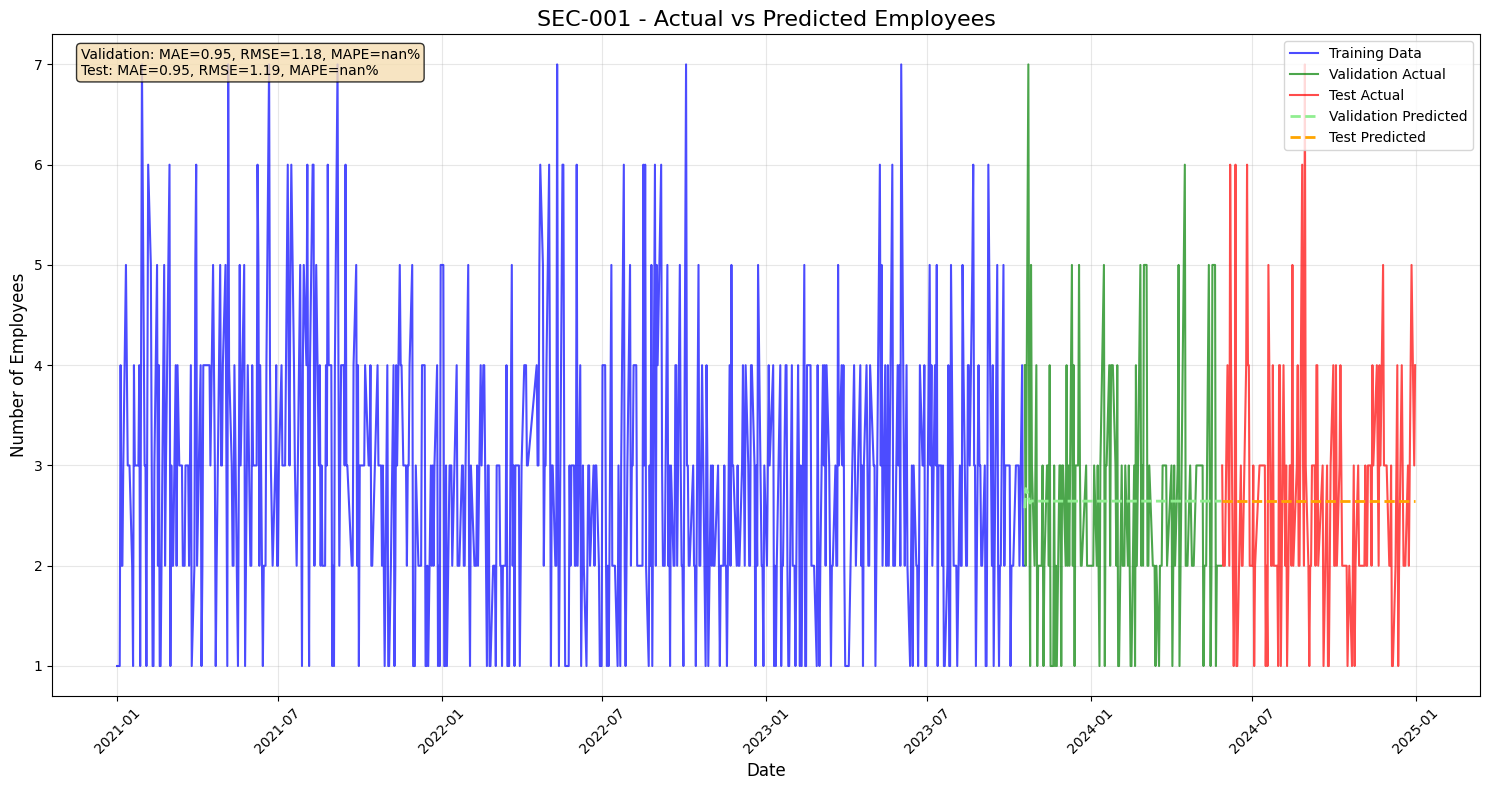

In [24]:
# Plot results for Section 1
plot_predictions(0, 'SEC-001')

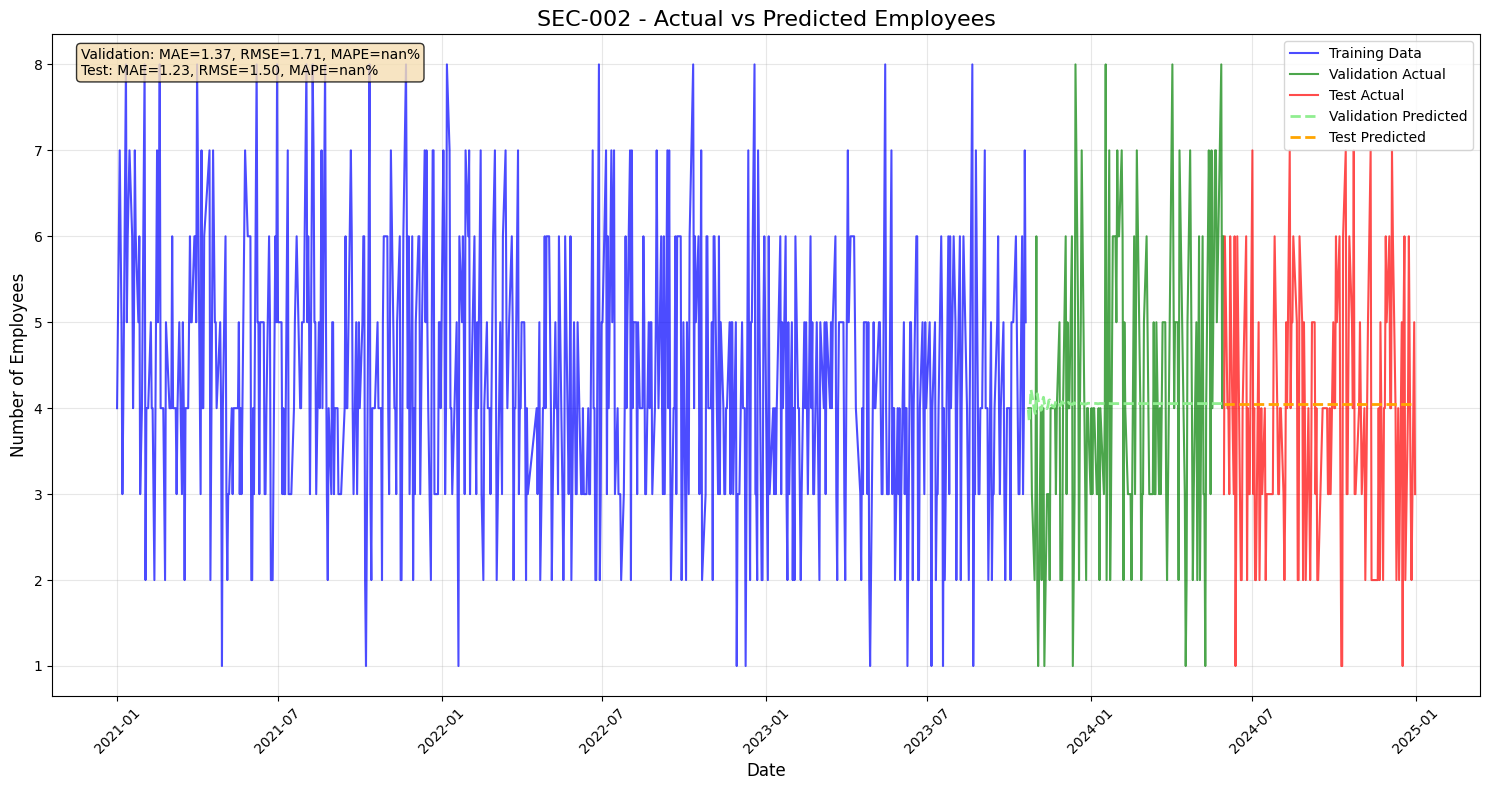

In [25]:
# Plot results for Section 2
plot_predictions(1, 'SEC-002')

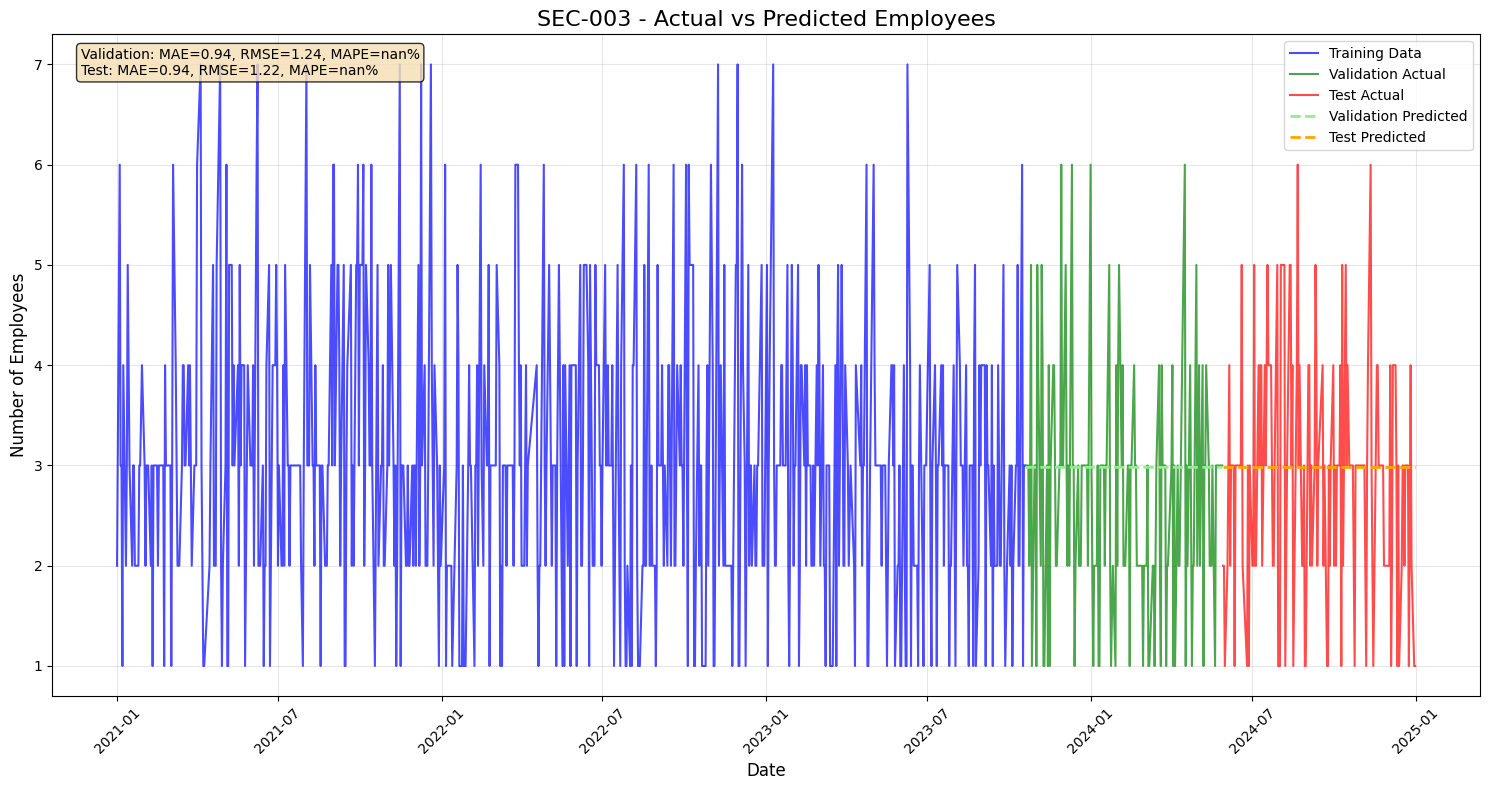

In [26]:
# Plot results for Section 3
plot_predictions(2, 'SEC-003')

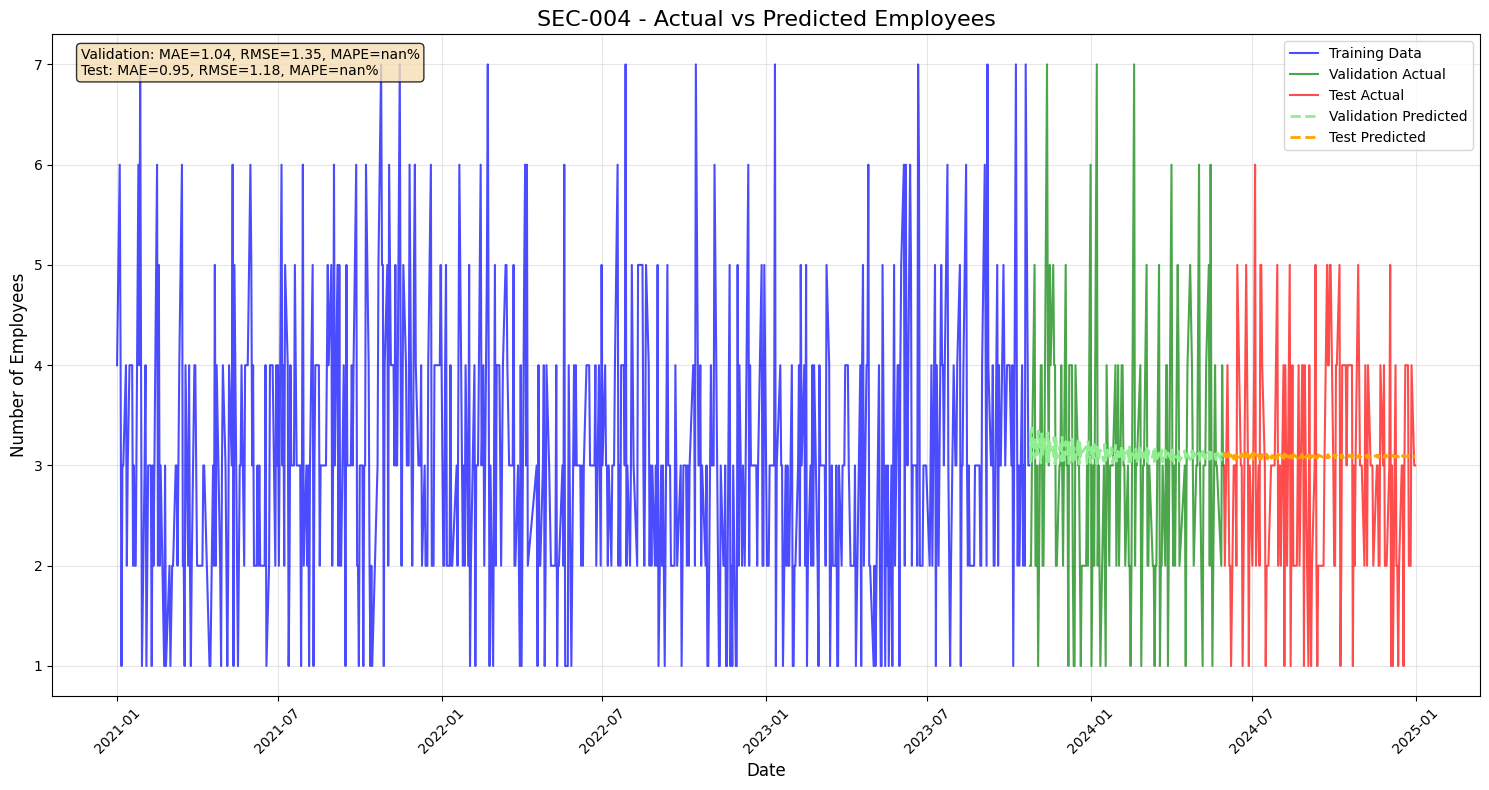

In [27]:
# Plot results for Section 4
plot_predictions(3, 'SEC-004')

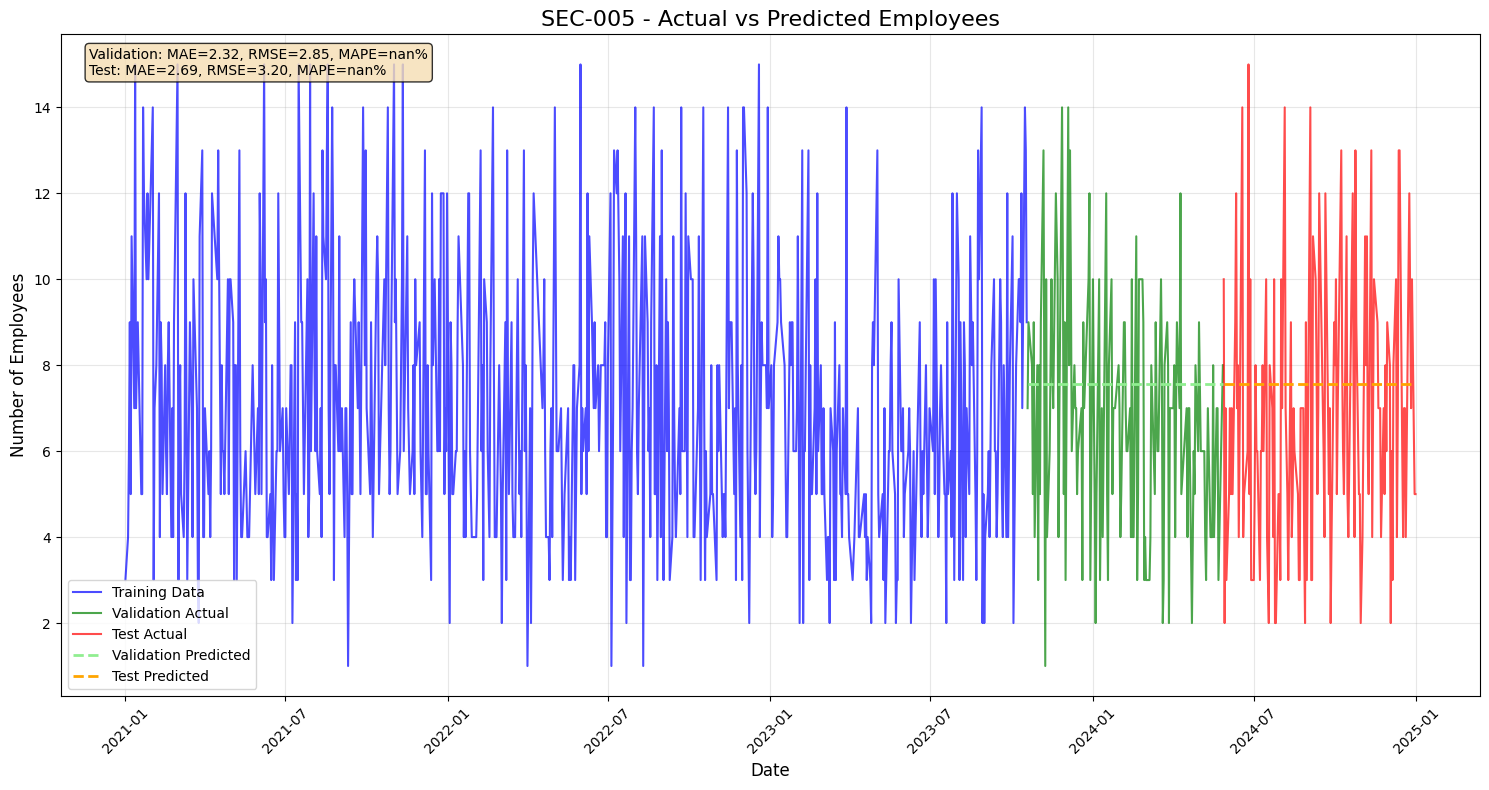

In [28]:
# Plot results for Section 5
plot_predictions(4, 'SEC-005')

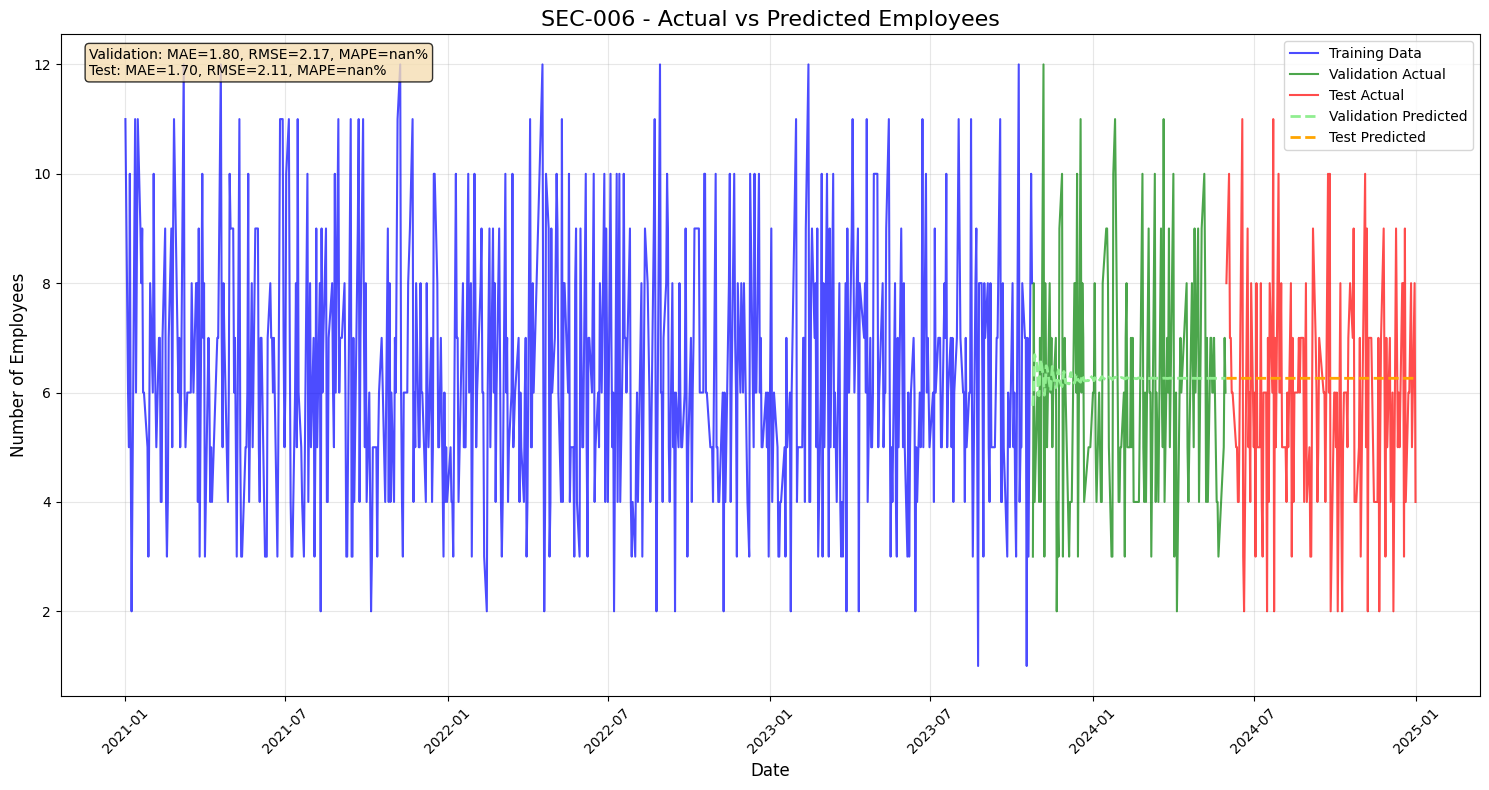

In [29]:
# Plot results for Section 6
plot_predictions(5, 'SEC-006')

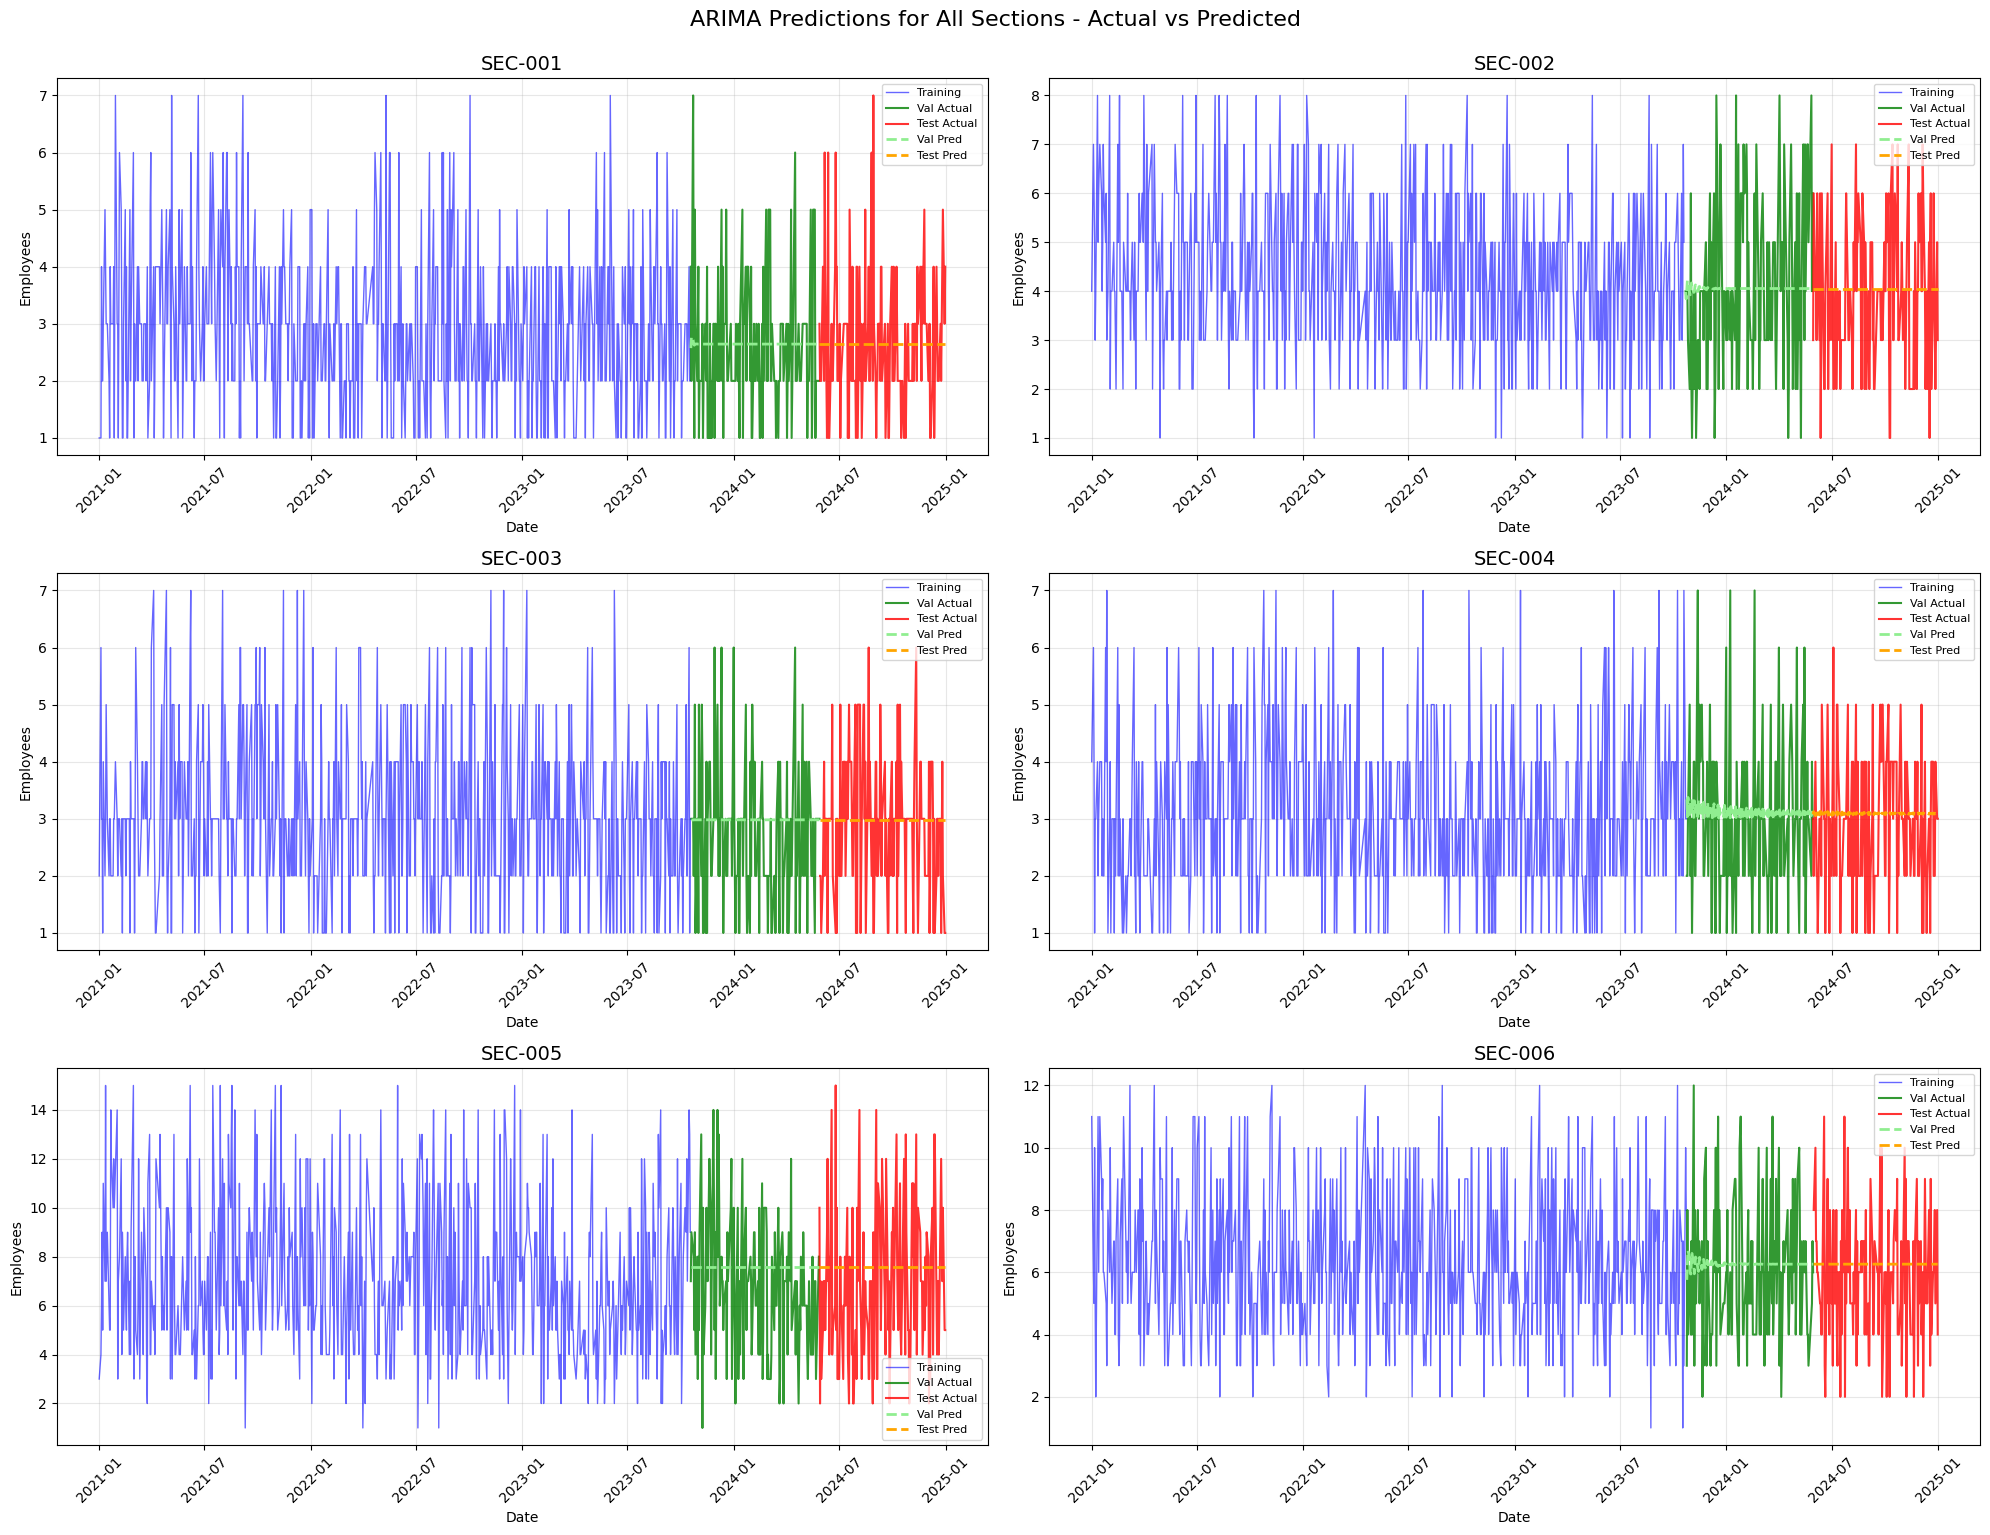

In [30]:
# Create a comprehensive comparison plot
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()

for i, section in enumerate(section_names):
    train_data = train_sets[i]
    val_data = val_sets[i]
    test_data = test_sets[i]
    val_pred = all_predictions[section]['val_pred']
    test_pred = all_predictions[section]['test_pred']
    
    ax = axes[i]
    
    # Plot actual data
    ax.plot(train_data.index, train_data['employees_on_duty'], 
            label='Training', color='blue', alpha=0.6, linewidth=1)
    ax.plot(val_data.index, val_data['employees_on_duty'], 
            label='Val Actual', color='green', alpha=0.8, linewidth=1.5)
    ax.plot(test_data.index, test_data['employees_on_duty'], 
            label='Test Actual', color='red', alpha=0.8, linewidth=1.5)
    
    # Plot predictions
    ax.plot(val_data.index, val_pred, 
            label='Val Pred', color='lightgreen', linestyle='--', linewidth=2)
    ax.plot(test_data.index, test_pred, 
            label='Test Pred', color='orange', linestyle='--', linewidth=2)
    
    ax.set_title(f'{section}', fontsize=14)
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Employees', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Rotate x-axis labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.suptitle('ARIMA Predictions for All Sections - Actual vs Predicted', fontsize=16, y=1.02)
plt.show()

In [31]:
# Create performance summary
print("=" * 80)
print("PERFORMANCE SUMMARY - ALL SECTIONS")
print("=" * 80)

summary_df = pd.DataFrame()

for section in section_names:
    val_metrics = all_metrics[section]['val_metrics']
    test_metrics = all_metrics[section]['test_metrics']
    
    row_data = {
        'Section': section,
        'Val_MAE': val_metrics['MAE'],
        'Val_RMSE': val_metrics['RMSE'], 
        'Val_MAPE': val_metrics['MAPE'],
        'Val_ACC': val_metrics['ACC'],
        'Test_MAE': test_metrics['MAE'],
        'Test_RMSE': test_metrics['RMSE'],
        'Test_MAPE': test_metrics['MAPE'],
        'Test_ACC': test_metrics['ACC']
    }
    
    summary_df = pd.concat([summary_df, pd.DataFrame([row_data])], ignore_index=True)

# Display the summary table
print(summary_df.round(2).to_string(index=False))

# Calculate average performance
print("\n" + "=" * 50)
print("AVERAGE PERFORMANCE ACROSS ALL SECTIONS")
print("=" * 50)
print(f"Average Validation MAE: {summary_df['Val_MAE'].mean():.2f}")
print(f"Average Validation RMSE: {summary_df['Val_RMSE'].mean():.2f}")
print(f"Average Validation MAPE: {summary_df['Val_MAPE'].mean():.2f}%")
print(f"Average Test MAE: {summary_df['Test_MAE'].mean():.2f}")
print(f"Average Test RMSE: {summary_df['Test_RMSE'].mean():.2f}")
print(f"Average Test MAPE: {summary_df['Test_MAPE'].mean():.2f}%")

PERFORMANCE SUMMARY - ALL SECTIONS
Section  Val_MAE  Val_RMSE  Val_MAPE  Val_ACC  Test_MAE  Test_RMSE  Test_MAPE  Test_ACC
SEC-001     0.95      1.18       NaN    -0.00      0.95       1.19        NaN     -0.00
SEC-002     1.37      1.71       NaN    -0.00      1.23       1.50        NaN     -0.03
SEC-003     0.94      1.24       NaN    -0.08      0.94       1.22        NaN     -0.02
SEC-004     1.04      1.35       NaN    -0.03      0.95       1.18        NaN     -0.03
SEC-005     2.32      2.85       NaN    -0.09      2.69       3.20        NaN     -0.08
SEC-006     1.80      2.17       NaN    -0.02      1.70       2.11        NaN     -0.05

AVERAGE PERFORMANCE ACROSS ALL SECTIONS
Average Validation MAE: 1.40
Average Validation RMSE: 1.75
Average Validation MAPE: nan%
Average Test MAE: 1.41
Average Test RMSE: 1.74
Average Test MAPE: nan%
